In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import norm


import matplotlib as mpl
from matplotlib import cm
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from astroML.datasets import fetch_rrlyrae_combined
from astroML.classification import GMMBayes
from astroML.utils import split_samples
from astroML.datasets import fetch_imaging_sample







# Section 1: Gussian Mixture Model

## - develop 3 approaches for classifying time series
### the initial approach should extract features from a time series (e.g. using cesium-ml) and apply a GMM classifier (you will need to define how you will classify a continuous function such as period). The classifier should be robust to changes in the phase of the time series

### Read in time-series data

In [2]:
def plot_timeseries(df: pd.DataFrame, indx=0 ) -> None:
    '''Plot the generated time series data.
        Args:
            df: Pandas DataFrame with the generated data
            indx: index of the time series to plot
        '''
    df[f'y{indx}' ].plot(style='o')  

    plt.show()

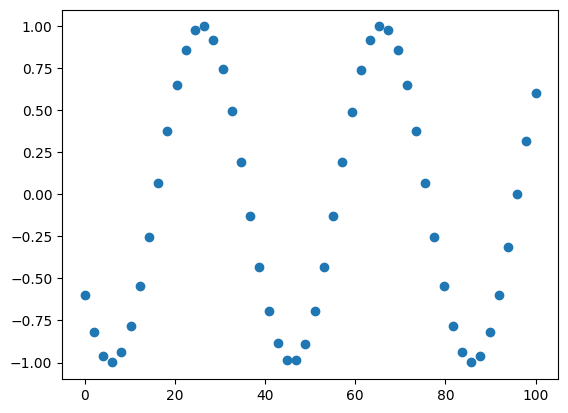

(50, 100000)


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y99990,y99991,y99992,y99993,y99994,y99995,y99996,y99997,y99998,y99999
0.000000,-0.987242,-0.735776,-0.835780,0.368300,0.993337,0.607363,0.991060,0.913201,0.988297,-0.428671,...,-0.952394,-0.604454,-0.980924,-0.895995,0.947058,0.995710,0.072077,0.894138,-0.717289,-0.824622
2.040816,-0.886773,-0.484893,-0.966216,0.056579,0.906416,0.826751,0.982612,0.738269,0.986016,-0.122144,...,-0.999942,-0.322633,-0.869696,-0.710421,0.797642,0.915826,0.382694,0.707484,-0.461188,-0.960864
4.081633,-0.695953,-0.184606,-0.998207,-0.260906,0.727141,0.961903,0.874048,0.488116,0.883272,0.196827,...,-0.945608,-0.007939,-0.669857,-0.452464,0.566956,0.742629,0.654319,0.448745,-0.158096,-0.999205
6.122449,-0.434223,0.134491,-0.928491,-0.551809,0.473780,0.999047,0.676428,0.188229,0.690533,0.495744,...,-0.794927,0.307564,-0.401767,-0.148405,0.278503,0.493768,0.859276,0.144284,0.161103,-0.935738
8.163265,-0.128251,0.439885,-0.764173,-0.786488,0.172146,0.934401,0.409888,-0.130836,0.427436,0.744150,...,-0.563253,0.591730,-0.092741,0.170774,-0.038327,0.194597,0.976682,-0.174877,0.463888,-0.776931


In [3]:
ts_single_freq_df = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_single_frequency.feather')
ts_single_freq_df.head()
plot_timeseries(ts_single_freq_df, indx=1000)
print(ts_single_freq_df.shape)
ts_single_freq_df.head()

In [4]:
# # # df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
# df_A = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')
# df_A.head()
# plot_timeseries(df_A, indx=10)
# plot_timeseries(df_A, indx=25)

In [5]:
# # df_A = pd.read_csv('/home/jovyan/COURSE_MATERIALS/lectures/data/fieldA.csv')
# df_A = pd.read_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/timeseries_multiple_frequency_sampled.feather')
# df_A.head()
# plot_timeseries(df_A, indx=10)

### Read in periods from Tobin

In [6]:
import pandas as pd

# Read data from pickle file
single_freq_periods = np.array(pd.read_pickle('/Users/mmckay/Desktop/astr598_spr24_classification_repo/DATA/periods_single_freq.pkl'))

# Display the dataframe
single_freq_periods.shape

(100000,)

### Part 1: Using cesium-ml to extract features

In [8]:
from cesium import featurize

features_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average",
    "period_fast"
]
fset_cesium = featurize.featurize_time_series(
    times=np.array(ts_single_freq_df.index),
    values=np.array(ts_single_freq_df[:].transpose()),
    errors=None,
    features_to_use=features_to_use,
)

fset_cesium.shape

(1, 1200000)

In [10]:
# Save the featurized data
fset_cesium.to_csv('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/featurized_single_freq.csv')
fset_cesium.to_feather('/Users/mmckay/Desktop/astr598_spr24_classification_repo/data/featurized_single_freq.feather')

### Visualize Cesium features for timeseries

In [14]:
fset_cesium['weighted_average'].loc[0].describe()

count    100000.000000
mean          0.000336
std           0.087394
min          -0.123707
25%          -0.086713
50%           0.000277
75%           0.087626
max           0.123707
Name: 0, dtype: float64

<Axes: xlabel='0', ylabel='Count'>

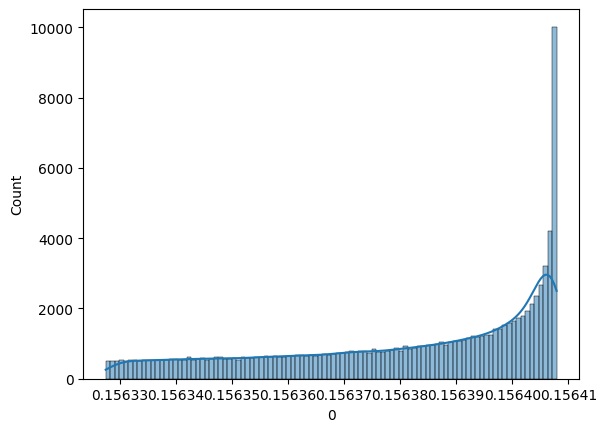

In [16]:
sns.histplot(fset_cesium['max_slope'].loc[0], bins=100, kde=True)

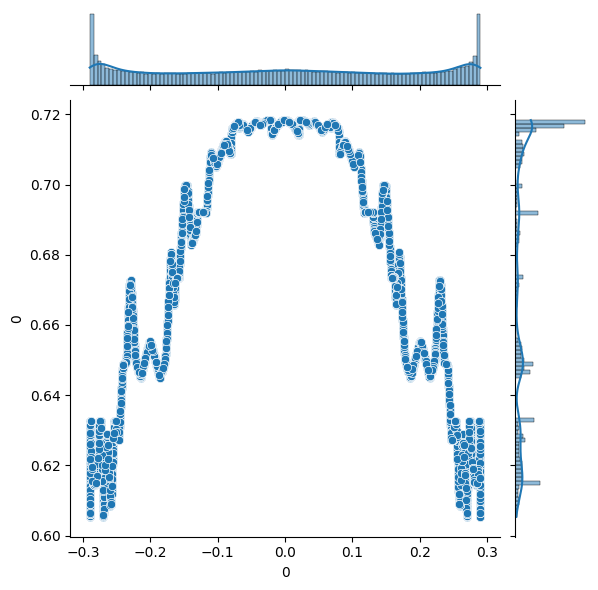

In [28]:
# Assuming you have two features 'feature1' and 'feature2' in your fset_cesium DataFrame
feature1 = fset_cesium['skew'].loc[0]
feature2 = fset_cesium['median_absolute_deviation'].loc[0]

sns.jointplot(x=feature1, y=feature2, kind='scatter', marginal_kws=dict(bins=100, kde=True))

plt.show()

In [136]:
# fset_cesium[['amplitude', 'median_absolute_deviation']].loc[0][0:10]

feature    channel
amplitude  0          0.999486
           1          0.999464
           2          0.998829
           3          0.999458
           4          0.999299
           5          0.998108
           6          0.999136
           7          0.999482
           8          0.999461
           9          0.999470
Name: 0, dtype: float64

In [ ]:
# fset_cesium['median']
# sns.pairplot(fset_cesium[:].loc[1:10], hue='median')

### Formating feature dataframe for GMMBayes classifyer

In [79]:
# Create feature dataframe for data split and model training
feature_df = np.reshape(fset_cesium[['median', 'amplitude']], (-1, 2))
feature_df.shape

# If we want to read in the complete timeseries
ts_single_freq_df.transpose().shape

(100000, 2)

Use Decrete fourier transfrom to descrtize the the contious function of period

In [112]:
from scipy.fftpack import fft

# Create a simple sinusoidal signal
t = np.linspace(0, 1, 500, endpoint=False)
# signal = 0.5 * np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
signal = ts_single_freq_df['y100']

# Compute the FFT of the signal
fft_result = fft(signal)

# Compute the magnitudes of the FFT
fft_magnitudes = np.abs(fft_result)

# Plot the FFT magnitudes
plt.figure(figsize=(12, 6))
plt.plot(fft_magnitudes[:len(fft_magnitudes)//2])
plt.title('FFT Magnitudes')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

KeyError: 'ALIGNED'

#### Data Split

In [81]:
# Data Split
X = np.array(feature_df) # (100000, cesium feature)
y = np.array(single_freq_periods)

(X_train, X_valid, X_test), (y_train, y_valid, y_test) = split_samples(X, y, [0.8, 0.1, 0.1], random_state=0)
print(f'Training set N={len(X_train)}, Shape:{X_train.shape}\nTesting set N={len(X_test)}, Shape:{X_test.shape} \nValidation set N={len(X_valid)}, Shape:{X_valid.shape}') 

Training set N=80000, Shape:(80000, 2)
Testing set N=10000, Shape:(10000, 2) 
Validation set N=10000, Shape:(10000, 2)


### Gussian Mixture Model Bayes

In [100]:
# Apply GMM classifers to training set
labels = ['median', 'amplitude']

# train a Gaussian Mixture Bayes classifier with 2 gaussians for each class
gmmb = GMMBayes(n_components=4, random_state=0)
gmmb.fit(X_train, y_train)

print(f'Accuracy: {gmmb.score(X_valid, y_valid)}')

ValueError: continuous is not supported

In [99]:
y_pred = gmmb.predict(X_valid)

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
# print('Stars vs Galaxies Recall %0.3f' % recall_score(y_valid, y_pred))
# print('Stars vs Galaxies Precision %0.3f' % precision_score(y_valid, y_pred))

threshold = 0.5  # Set the threshold for classification 
y_pred_discrete = np.where(y_pred >= threshold, 1, 0)  # Convert continuous predictions to discrete values


print(classification_report(y_valid, y_pred))

ValueError: continuous is not supported

ValueError: continuous is not supported

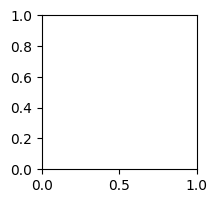

In [89]:
y_pred = gmmb.predict(X_valid)

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot()
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred, display_labels=labels, cmap='Blues', ax=ax)
plt.show()

# when there are only two classes, scikit-learn will calculate the precision/recall for class=1 only
print('RR Lyrae Recall %0.3f' % recall_score(y_valid, y_pred))
print('RR Lyrae Precision %0.3f' % precision_score(y_valid, y_pred))

# Section 2: Convolutional Nural Network

# Section 3: 